<a href="https://colab.research.google.com/github/AbhiAadi/DeepONet/blob/main/MTPduffingoscillator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install gstools

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.7/167.7 kB 24.6 MB/s eta 0:00:00


In [ ]:
import numpy as np
from numpy import load
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from math import e
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Dense, Multiply, Lambda,SimpleRNN, Dropout, LSTM
from keras.models import Model
from keras.utils import plot_model
from gstools import SRF, Gaussian
from gstools.random import MasterRNG
from scipy.interpolate import interp1d
from scipy.integrate import odeint

In [ ]:
m = 100 #sampling points for discretizing functions
p = 100  #points where output is measured
n = 150  #number of different functions
tparams = 1  #parameters given to trunk net
#ntemp = 40   #initial conditions values

In [ ]:
x = np.linspace(0,1, m)

In [ ]:
seed = MasterRNG(20170519)
def one_function(x):
    model = Gaussian(dim=1, var=3, len_scale=0.5)  #increase len_scale value to get smoother curves
    srf = SRF(model, seed=seed())
    f = srf.structured([x])
    return f

In [ ]:
U = np.zeros((m, n)) #forcing function
for i in range(n):
    U[:, i] = one_function(x)

In [ ]:
# y is matrix containing u and u', t=time, xinterp=discrete location, finterp=value of GRF
# initial_conditions=Initial values of u and v
def duffing_ode_oscillator(initial_conditions, t1, xinterp, finterp):
  interpolant = interp1d(xinterp, finterp, fill_value="extrapolate")
  def ode_system(y, t):
    u, v = y
    return [v, interpolant(t) - 0.05*v - u**3]
  result = odeint(ode_system, initial_conditions, t1)
  return result

In [ ]:
initial_conditions = np.random.normal(loc=2, scale=1, size=(n,2))

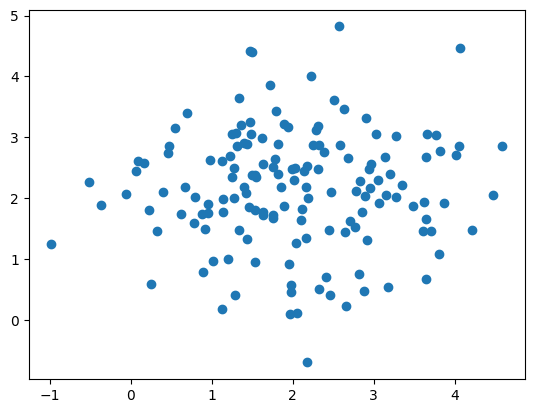

In [ ]:
plt.scatter(initial_conditions[:,0],initial_conditions[:,1])
plt.show()

In [ ]:
'''plt.plot(initial_conditions[:,1])
plt.show()'''
initial_conditions[n-1,0]

2.1355400630080243

In [ ]:
S = np.zeros((m,2,n))
for i in range(n):
  S[:,:,i] = duffing_ode_oscillator(initial_conditions[i], x[:m], x, U[:,i])

In [ ]:
modx = np.linspace(-4,4,100)
mody = 0.25*modx**4

In [ ]:
fig = plt.figure()
axis = plt.axes(xlim =(-6, 6),ylim =(-1, 64))
axis.set_xlabel('Displacement')
axis.set_ylabel('Potential Energy')
axis.set_title('Potential Energy v/s Time')
# initializing a line variable
line, = axis.plot(modx,mody)
point, = axis.plot([], [], 'ro')
def animate(i):
  point_data = []
  point_data.append((S[i,0,1], 0.25*S[i,0,1]**4))
  point.set_data(*zip(*point_data))
  return line,point

ani = animation.FuncAnimation(fig, animate,frames=100, interval=100, blit = True)
html = ani.to_html5_video()
plt.close()
HTML(html)

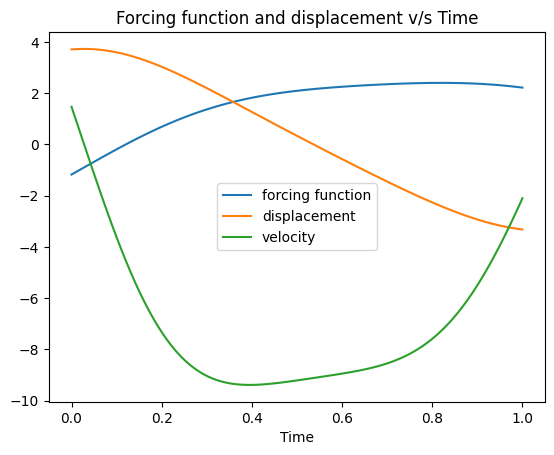

In [ ]:
#for func_num in range(n):
func_num = 1
plt.plot(x, U[:,func_num], label="forcing function")
plt.plot(x[:m], S[:,0,func_num],label="displacement")
plt.plot(x[:m], S[:,1,func_num],label="velocity")
plt.legend()
plt.xlabel("Time")
plt.title("Forcing function and displacement v/s Time")
plt.show()

In [ ]:
def interate_dataset(m=m, n=n , p=p, x=x, U=U, S=S, initial_conditions=initial_conditions):
    us = np.zeros((p*n, m))
    xs = np.zeros((p*n, 3))
    ss = np.zeros((p*n, 1))
    for i in range(n):
        for j in range(p):
            us[i*p+j, :] = U[:m, i]
            xs[i*p+j, 0] = x[j]
            xs[i*p+j, 1] = initial_conditions[i,0]
            xs[i*p+j, 2] = initial_conditions[i,1]
            ss[i*p+j, :] = S[j,0,i]
    return us, xs, ss

In [ ]:
us, xs, ss = interate_dataset()
us.shape, xs.shape, ss.shape

((15000, 100), (15000, 3), (15000, 1))

In [ ]:
# T means trunk net, B means branch net
def build_deeponet_model(m,tparams,hub,hut,huc,bnethl,tnethl,blact,tlact):
  initializer = tf.keras.initializers.GlorotNormal
  I1 = Input(shape=(m,),name='Branch_Net-Input')
  x = I1
  for i in range(bnethl):
    if i%2==0:
      x = Dense(hub, activation='linear',name=f"B{i}", kernel_initializer=initializer)(x)
    else:
      x = Dense(hub, activation=blact,name=f"B{i}", kernel_initializer=initializer)(x)
  B5 = Dense(huc, activation='linear',name=f"B{bnethl}", kernel_initializer=initializer)(x)
  I2 = Input(shape=(1,),name='Trunk_Net-Input')
  x = I2
  for i in range(tnethl):
    if i%2==0:
      x = Dense(hut, activation='linear',name=f"T{i}", kernel_initializer=initializer)(x)
    else:
      x = Dense(hut, activation=tlact,name=f"T{i}", kernel_initializer=initializer)(x)
  T5 = Dense(huc, activation='linear',name=f"T{tnethl}")(x)
  I3 = Input(shape=(2,),name='Branch_Net-Initial-cond')
  x = I3
  for i in range(bnethl):
    if i%2==0:
      x = Dense(hub, activation='linear',name=f"B1{i}", kernel_initializer=initializer)(x)
    else:
      x = Dense(hub, activation=blact,name=f"B1{i}", kernel_initializer=initializer)(x)
  B15 = Dense(huc, activation='linear',name=f"B1{bnethl}", kernel_initializer=initializer)(x)
  combined = Multiply(name='Elementwise_multiplication')([B5,B15])
  x = combined
  for i in range(bnethl-2):
    if i%2==0:
      x = Dense(hub, activation='linear',name=f"B2{i}", kernel_initializer=initializer)(x)
    else:
      x = Dense(hub, activation=blact,name=f"B2{i}", kernel_initializer=initializer)(x)
  B25 = Dense(huc, activation='linear',name=f"B2{bnethl}", kernel_initializer=initializer)(x)
  combined1 = Multiply(name='Elementwise_multiplication1')([B25,T5])
  F1 =  Lambda(lambda x: (tf.reduce_sum(x,1,keepdims=True)),name='Final_sum', output_shape = (None,1))(combined1)
  deeponet = Model(inputs=[I1,I2,I3],outputs=F1)
  return deeponet

In [ ]:
hub = 100
hut = 140
huc = 100
bnethl = 5
tnethl = 6
blact = 'relu'
tlact = 'relu'

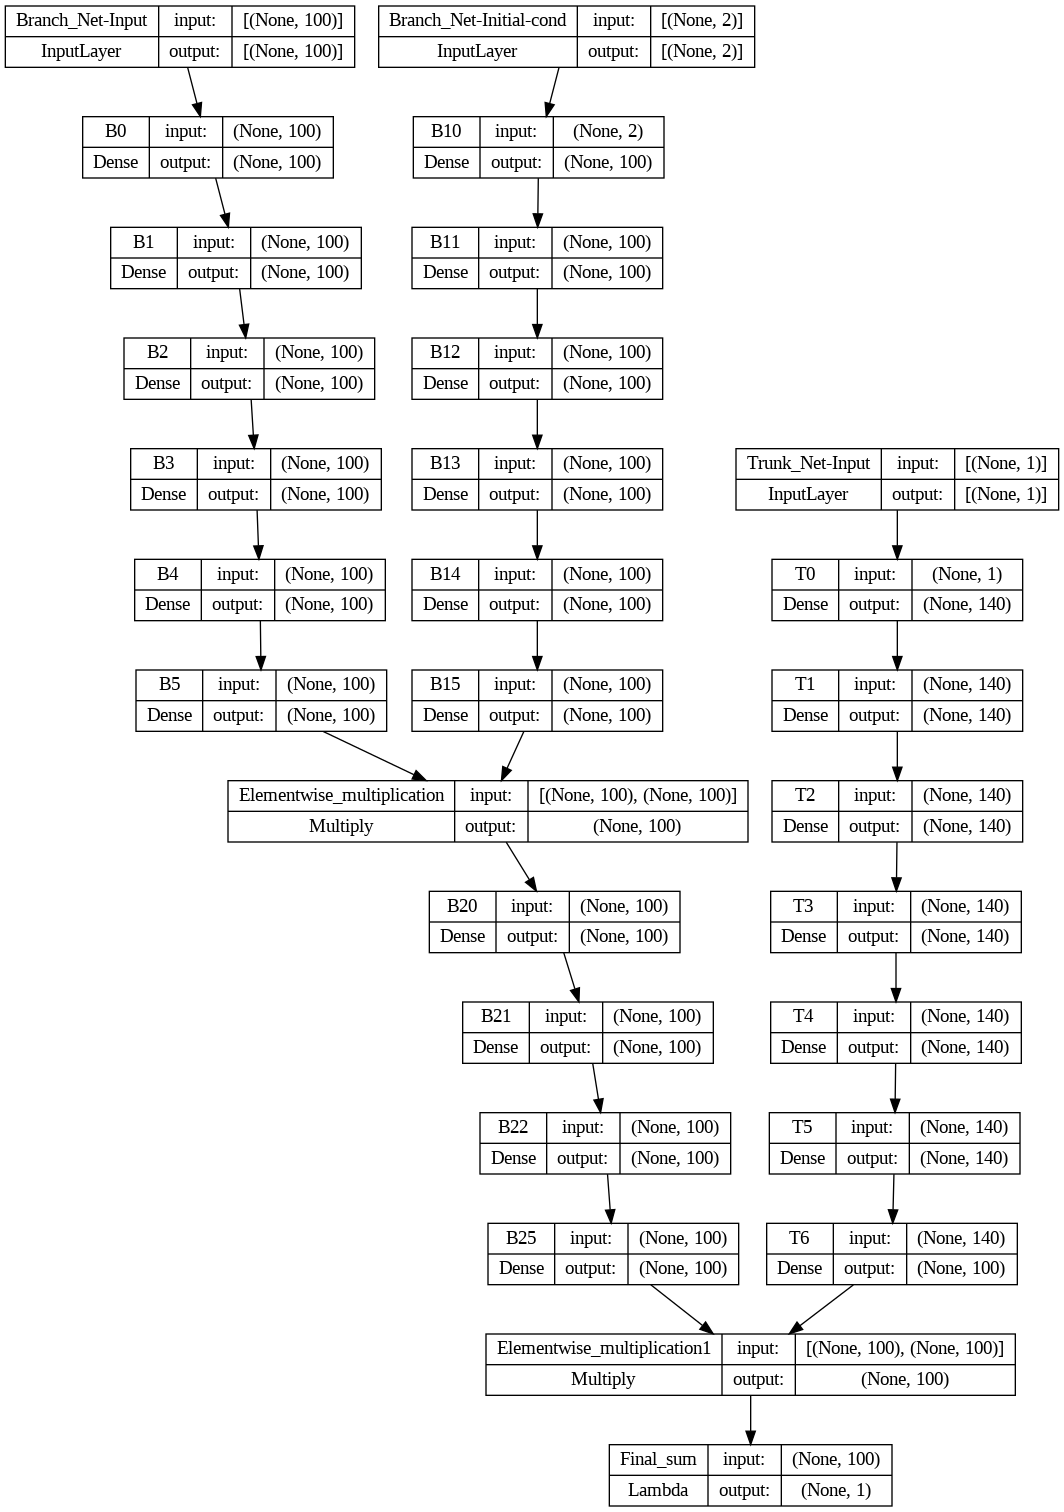

In [ ]:
deeponet = build_deeponet_model(m,tparams,hub,hut,huc,bnethl,tnethl,blact,tlact)
plot_model(deeponet,show_shapes=True)

In [ ]:
deeponet.compile(optimizer = keras.optimizers.Adam(learning_rate=0.0001), loss='mae', metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [ ]:
losses = deeponet.fit([us, xs[:,0:1],xs[:,1:3]],ss,epochs=200,batch_size=200,)

Epoch 1/200
75/75 [==============================] - 6s 18ms/step - loss: 1.0991 - root_mean_squared_error: 1.3848
Epoch 2/200
75/75 [==============================] - 2s 28ms/step - loss: 0.6119 - root_mean_squared_error: 0.8158
Epoch 3/200
75/75 [==============================] - 2s 25ms/step - loss: 0.3813 - root_mean_squared_error: 0.5388
Epoch 4/200
75/75 [==============================] - 1s 20ms/step - loss: 0.2291 - root_mean_squared_error: 0.3377
Epoch 5/200
75/75 [==============================] - 1s 17ms/step - loss: 0.1670 - root_mean_squared_error: 0.2459
Epoch 6/200
75/75 [==============================] - 1s 18ms/step - loss: 0.1397 - root_mean_squared_error: 0.2007
Epoch 7/200
75/75 [==============================] - 1s 18ms/step - loss: 0.1078 - root_mean_squared_error: 0.1550
Epoch 8/200
75/75 [==============================] - 1s 18ms/step - loss: 0.0901 - root_mean_squared_error: 0.1290
Epoch 9/200
75/75 [==============================] - 1s 17ms/step - loss: 0.0701

In [ ]:
def trunk_net_char(layer_name,inp):
  # Retrieve the desired layer
  trunk_layer_output = deeponet.get_layer(layer_name)
  if trunk_layer_output is None:
      raise ValueError(f"Layer '{layer_name}' does not exist in the model.")
  # Define a new model that outputs the activations at the desired layer
  trunk_output_model = tf.keras.Model(inputs=deeponet.input, outputs=trunk_layer_output.output)
  # Get the output at the desired layer
  trunk_output = trunk_output_model.predict(inp)
  # Print the activations at the desired layer
  print(trunk_output.shape)
  #trunk net output is independent of function, depends only on position
  plt.figure()
  for i in range(n):
    pnt = 0
    plt.plot(trunk_output[pnt+(100*i)])
  plt.title("Trunk-Net Output function for various functions at point 0")
  plt.show()
  xplt = np.linspace(0,100,101)
  fig = plt.figure()
  axis = plt.axes(xlim =(0, 100),ylim =(-0.6, 0.6))
  # initializing a line variable
  line, = axis.plot([],[])
  def animate(i):
      plt.title(f"Trunk-Net Output function at location {i+1}")
      point_data = [(xplt[:100], trunk_output[i])]
      line.set_data(*zip(*point_data))
      return line,
  ani = animation.FuncAnimation(fig, animate,frames=100, interval=400, blit = True)
  html1 = ani.to_html5_video()
  plt.close()
  fig = plt.figure()
  axis = plt.axes(xlim =(0, 1),ylim =(-0.6, 0.6))
  plt.xlabel("Location")
  # initializing a line variable
  line, = axis.plot([],[])
  def animate(i):
      plt.title(f"Trunk-Net Output function at node {i+1}")
      point_data = [(x, trunk_output[:100,i])]
      line.set_data(*zip(*point_data))
      return line,
  ani = animation.FuncAnimation(fig, animate,frames=100, interval=400, blit = True)
  html2 = ani.to_html5_video()
  plt.close()
  return html1,html2

469/469 [==============================] - 1s 3ms/step
(15000, 100)


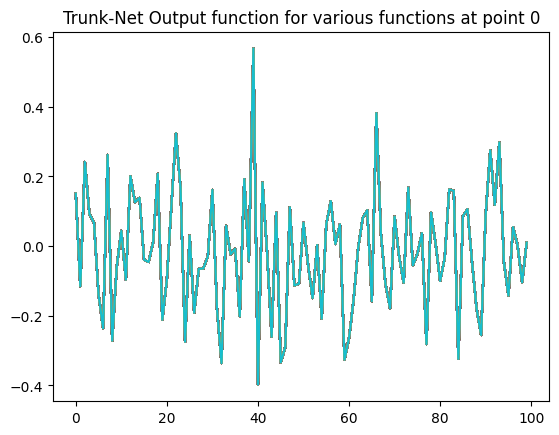

In [ ]:
html1,html2 = trunk_net_char("T6",[us, xs[:,0:1],xs[:,1:3]])

In [ ]:
HTML(html1)

In [ ]:
HTML(html2)

In [ ]:
def branch_net_char(layer_name,inp):
  # Retrieve the desired layer
  branch_layer_output = deeponet.get_layer(layer_name)
  if branch_layer_output is None:
      raise ValueError(f"Layer '{layer_name}' does not exist in the model.")
  # Define a new model that outputs the activations at the desired layer
  branch_output_model = tf.keras.Model(inputs=deeponet.input, outputs=branch_layer_output.output)
  # Get the output at the desired layer
  branch_output = branch_output_model.predict(inp)
  # Print the activations at the desired layer
  print(branch_output.shape)
  #branch net output is independent of location, depends only on function
  plt.figure()
  for i in range(p):
    plt.plot(branch_output[i])
  plt.title("Branch-Net Output function for various locations at function 0")
  plt.show()
  xplt = np.linspace(0,100,101)
  fig, axes = plt.subplots(1, 2, figsize=(16, 4))
  def animate(i):
      axes[0].cla()
      line1, = axes[0].plot(xplt[:100], branch_output[(100*i)])
      axes[0].set_xlim(0, 100)
      axes[0].set_ylim(-2, 2)
      axes[0].set_title(f"Branch-Net Output function at function {i+1}")
      axes[1].cla()
      line2, = axes[1].plot(xplt[:100], us[(100*i)])
      axes[1].set_xlim(0, 100)
      axes[1].set_ylim(-10, 10)
      axes[1].set_title(f"Branch-Net Input function {i+1}")
      return line1,line2
  ani = animation.FuncAnimation(fig, animate,frames=150, interval=500, blit = True)
  html = ani.to_html5_video()
  plt.close()
  return html

469/469 [==============================] - 1s 2ms/step
(15000, 100)


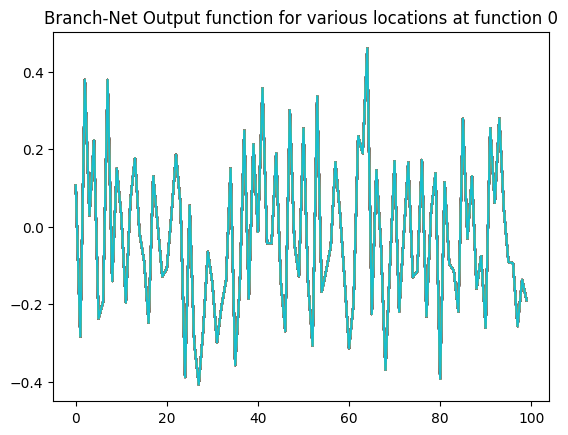

In [ ]:
html= branch_net_char("B25",[us, xs[:,0:1],xs[:,1:3]])

In [ ]:
HTML(html)

In [ ]:
deeponet.save('dufoscvar.h5')
model_json = deeponet.to_json()
with open("dufoscvar.json", "w") as json_file:
    json_file.write(model_json)

In [ ]:
with open('/content/dufoscmod1kepo.json', 'r') as json_file:
    json_savedModel= json_file.read()
#load the model architecture
model_j = tf.keras.models.model_from_json(json_savedModel)
model_j.load_weights('/content/dufoscmod1kepo.h5')
model_j.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])
model_j.summary()

In [ ]:
def odesys(y, t):
    u, v = y
    return [v, 5*np.sin(t) - 0.05*v - u**3]

In [ ]:
incond = [1,3.5]

In [ ]:
testt = np.linspace(0,1,m)

In [ ]:
u_t = 5*np.sin(testt)
s_t = odeint(odesys, incond, testt)[:,0]
outp_loc = testt

In [ ]:
modx = np.linspace(-6,6,100)
mody = 0.25*modx**4

In [ ]:
dm = []
dm1=[]
dm2=[]
for i in range(p):
  dm.append(u_t)
  j = outp_loc[i]
  dm2.append([j,incond[0],incond[1]])
  dm1.append([s_t[i]])

inp_func = np.asarray(dm)
outp_func = np.asarray(dm1) #output function
y = np.asarray(dm2)
print(outp_func.shape)
print(y.shape)
print(inp_func.shape)

(100, 1)
(100, 3)
(100, 100)


4/4 [==============================] - 0s 4ms/step


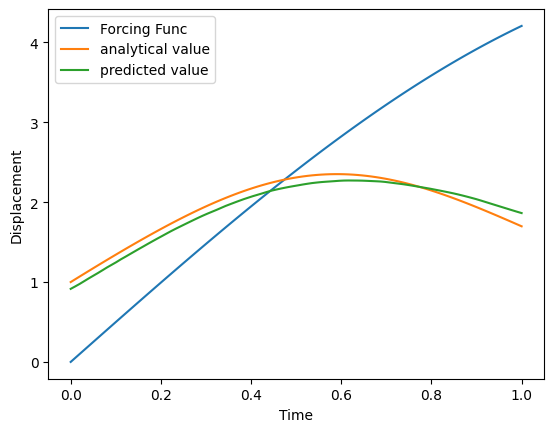

In [ ]:
pt = deeponet.predict([inp_func,y[:,0:1],y[:,1:3]])
plt.plot(testt, u_t, label="Forcing Func")
plt.plot(testt, s_t, label="analytical value")
plt.plot(testt, pt, label="predicted value")
plt.xlabel('Time')
plt.ylabel('Displacement')
plt.legend();

In [ ]:
# Specify the name of the layer you want to extract activations from
layer_name = "T6"
# Retrieve the desired layer
trunk_layer_output = deeponet.get_layer(layer_name)
if trunk_layer_output is None:
    raise ValueError(f"Layer '{layer_name}' does not exist in the model.")
# Define a new model that outputs the activations at the desired layer
trunk_output_model = tf.keras.Model(inputs=deeponet.input, outputs=trunk_layer_output.output)
# Get the output at the desired layer
trunk_output = trunk_output_model.predict([inp_func,y[:,0:1],y[:,1:3]])
# Print the activations at the desired layer
print(trunk_output.shape)

4/4 [==============================] - 0s 5ms/step
(100, 100)


In [ ]:
# Specify the name of the layer you want to extract activations from
layer_name = "B25"
# Retrieve the desired layer
branch_layer_output = deeponet.get_layer(layer_name)
if branch_layer_output is None:
    raise ValueError(f"Layer '{layer_name}' does not exist in the model.")
# Define a new model that outputs the activations at the desired layer
branch_output_model = tf.keras.Model(inputs=deeponet.input, outputs=branch_layer_output.output)
# Get the output at the desired layer
branch_output = branch_output_model.predict([inp_func,y[:,0:1],y[:,1:3]])
# Print the activations at the desired layer
print(branch_output.shape)

4/4 [==============================] - 0s 4ms/step
(100, 100)


In [ ]:
fig = plt.figure()
axis = plt.axes(xlim =(0, 1),ylim =(-0.6, 0.6))
plt.xlabel("Location")
# initializing a line variable
line, = axis.plot([],[])
def animate(i):
    plt.title(f"Trunk-Net Output function at node {i+1}")
    point_data = [(x, trunk_output[:100,i])]
    line.set_data(*zip(*point_data))
    return line,
ani = animation.FuncAnimation(fig, animate,frames=100, interval=400, blit = True)
html = ani.to_html5_video()
plt.close()
HTML(html)

In [ ]:
xplt = np.linspace(0,100,101)
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
def animate(i):
    axes[0].cla()
    line1, = axes[0].plot(xplt[:100], branch_output[(100*i)])
    axes[0].set_xlim(0, 100)
    axes[0].set_ylim(-2, 2)
    axes[0].set_title(f"Branch-Net Output function at function {i+1}")
    axes[1].cla()
    line2, = axes[1].plot(xplt[:100], inp_func[(100*i)])
    axes[1].set_xlim(0, 100)
    axes[1].set_ylim(-10, 10)
    axes[1].set_title(f"Branch-Net Input function {i+1}")
    return line1,line2
ani = animation.FuncAnimation(fig, animate,frames=1, interval=500, blit = True)
html = ani.to_html5_video()
plt.close()
HTML(html)

In [ ]:
pt[-1]

array([-2.9182973], dtype=float32)

In [ ]:
incond1 = odeint(odesys, incond, testt)[-1]

In [ ]:
incond1[0] = pt[-1][0]

In [ ]:
incond1

array([-2.91829729, 25.22481402])

In [ ]:
def odesys1(y, t):
    u, v = y
    return [v, 5*np.sin(t+1) - 0.05*v - u**3]

In [ ]:
u_t1 = 5*np.sin(testt+1)
s_t1 = odeint(odesys1, incond1, testt)[:,0]
outp_loc1 = testt

In [ ]:
dm = []
dm1=[]
dm2=[]
for i in range(p):
  dm.append(u_t1)
  j = outp_loc1[i]
  dm2.append([j,incond1[0],incond1[1]])
  dm1.append([s_t1[i]])

inp_func1 = np.asarray(dm)
outp_func1 = np.asarray(dm1) #output function
y1 = np.asarray(dm2)
print(outp_func1.shape)
print(y1.shape)
print(inp_func1.shape)

(100, 1)
(100, 3)
(100, 100)


4/4 [==============================] - 0s 3ms/step


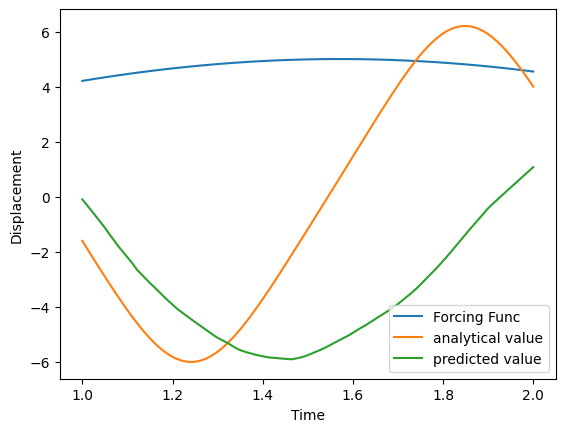

In [ ]:
pt1 = deeponet.predict([inp_func1,y1[:,0:1],y1[:,1:3]])
plt.plot(testt+1, u_t1, label="Forcing Func")
plt.plot(testt+1, s_t1, label="analytical value")
plt.plot(testt+1, pt1, label="predicted value")
plt.xlabel('Time')
plt.ylabel('Displacement')
plt.legend();

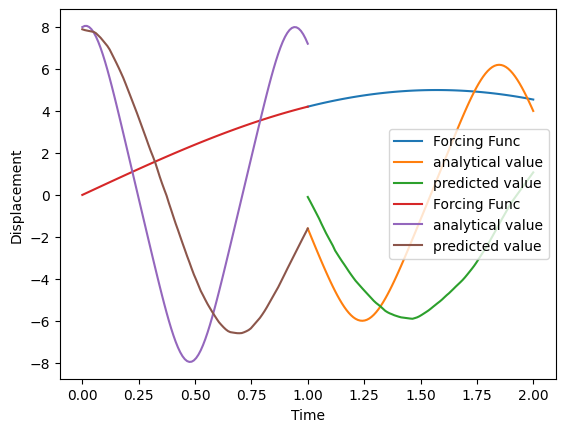

In [ ]:
plt.plot(testt+1, u_t1, label="Forcing Func")
plt.plot(testt+1, s_t1, label="analytical value")
plt.plot(testt+1, pt1, label="predicted value")
plt.plot(testt, u_t, label="Forcing Func")
plt.plot(testt, s_t, label="analytical value")
plt.plot(testt, pt, label="predicted value")
plt.xlabel('Time')
plt.ylabel('Displacement')
plt.legend();

In [ ]:

fig = plt.figure()
axis = plt.axes(xlim =(-6, 6),ylim =(-1, 40))
# initializing a line variable
line, = axis.plot(modx, mody)
point, = axis.plot([], [], 'ro')
def animate(i):
  point_data = []
  point_data.append((s_t[i], 0.25*s_t[i]**4))
  point.set_data(*zip(*point_data))
  return line,point

ani = animation.FuncAnimation(fig, animate,frames=100, interval=100, blit = True)
html = ani.to_html5_video()
plt.close()
HTML(html)